In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write, read
SAMPLE_RATE = 44100 

In [2]:
def convolution(weights, noisy_leftspeaker):
    temp_list = []
    # TRAVERSE BY INCREMENTING ONE
    for i in range(0, len(noisy_leftspeaker) - len(weights) + 1):
        # SLICING
        temp_list.append(np.sum( weights * noisy_leftspeaker[i : (i + len(weights))]))
    tmp_arr = np.array(temp_list)
    tmp_arr = np.insert(tmp_arr, 0,25)
    tmp_arr = np.append(tmp_arr,0)
    return tmp_arr

In [3]:
def movingaverage (values, window):
    weights = np.ones((1, window))/window
    weights = weights[0,:]
    sma = convolution(weights,values )
    sma =  pd.DataFrame(sma.reshape(1, -1)[0], columns=['moving_avg'])
    return sma

In [4]:
def mse_calculator(true_arr, predicted_arr):

    diff_arr = np.subtract(true_arr, predicted_arr)
    squared_arr = np.square(diff_arr)
    mse = squared_arr.mean()
    return mse[0]

In [5]:
def medfilt (x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
        
    median_filtered =  pd.DataFrame(np.median(y, axis=1).reshape(1, -1)[0], columns=['median_filt']) 
    return median_filtered

In [6]:
# Read wav file and turn into dataframe
# Seems like it is stereo file, just take one side. I took Left speaker
noisy_leftspeaker = np.array(read("suphi_noisy.wav")[1][:, 0])
noisy_signal = pd.DataFrame(noisy_leftspeaker.reshape(1, -1)[0], columns=['noisy_signal'])

clean_left = np.array(read("suphi_clean.wav")[1][:, 0])
clean_signal =  pd.DataFrame(clean_left.reshape(1, -1)[0], columns=['clean_signal'])

In [7]:
# Moving Average Filter and calculate MSE

moving_avg = movingaverage(noisy_leftspeaker,3)
MSE = mse_calculator(moving_avg,clean_signal)
print(MSE)

29536.649766374834


In [8]:
# Moving Average Filter and calculate MSE

median_filtered = medfilt(noisy_leftspeaker, 3)
MSE = mse_calculator(median_filtered,clean_signal)
print(MSE)

28530.72426699081


(570000, 570300)

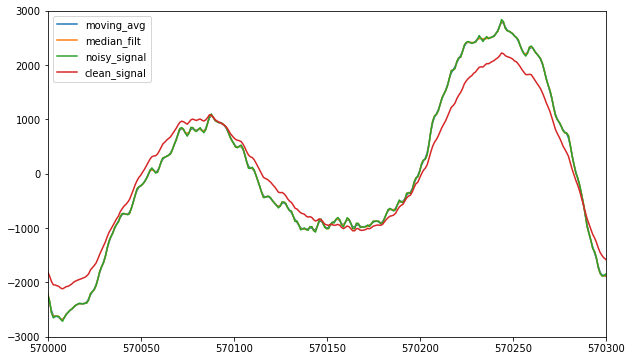

In [9]:
# Plotting noisy, filtered and clean signals

fig, ax = plt.subplots(figsize=(10,6))
moving_avg.plot(ax=ax)
median_filtered.plot(ax=ax)
noisy_signal.plot(ax=ax)
clean_signal.plot(ax=ax)
plt.ylim(-3000, 3000)
plt.xlim(570000,570300)

In [10]:
# turn denoised signal into wav file

# copy left speaker to right speaker
median_stereo = np.tile(median_filtered, (1, 2))
movavg_stereo = np.tile(moving_avg, (1, 2))

# write to wav
write("median_denoised.wav", SAMPLE_RATE, median_stereo)
write("movavg_denoised.wav", SAMPLE_RATE, movavg_stereo)

In [124]:
# Turning output format to kaggle challenge format

# copy left speaker to right speaker
stereo = np.tile(median_filtered, (1, 2))

# give column names and write to csv
df = pd.DataFrame(stereo,columns=["Left","Right"])
df.index.name='SampleID'
df.to_csv('Challenge.csv', index=True)